In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
import pandas as pd

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import UnitaryGate, HGate, SGate
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator, Pauli, Statevector, SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.options import EstimatorOptions, EnvironmentOptions
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2
from qiskit import transpile
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    # token='d971f21d7a3ef5423c79cb3cee59a1a2d2ebffbe7c6814abc54679456cd3005eafb563e6c1356898c29cfc8b038279958d966dc3d726c2ef7f7f87c2f03a5849' # Sara?
    token='656a2556246117cd382fba4bb957892cece054dad6a3102c567c2ef3ccd03b436e78e3c0529582e760cce684ff1c2c60b2e25ac01bd320e043db27d995a09f6f' # Stash
)


In [3]:
# Define parameters

phi_a, phi_b = np.pi/2, np.pi/4
theta_a, theta_b = np.pi/4, np.pi/8


def true_expected_value(phi, theta):
    """Calculate true expected value of M."""
    psi = np.array([np.cos(phi), 1j * np.sin(phi)])
    M = np.array([[0, np.exp(-theta*1j)], [np.exp(theta*1j), 0]])
    return psi.conj() @ M @ psi.T


true_ev_a = true_expected_value(phi_a, theta_a)
true_ev_b = true_expected_value(phi_b, theta_b)


# Helper functions

def one_qubit_circuit():
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    return QuantumCircuit(qr, cr), qr, cr


# Define the various circuits we need

def state_M(phi):
    return Statevector([np.cos(phi), 1j * np.sin(phi)])


def make_method_1_circuit(phi, theta) -> QuantumCircuit:
    psi = state_M(phi)

    # Unitary for measurement basis rotation
    U = UnitaryGate(
        (1/np.sqrt(2))*np.array([[1, 1], [np.exp(1j*theta), -np.exp(1j*theta)]]).T.conj())

    qc, qr, cr = one_qubit_circuit()
    qc.initialize(psi, 0)
    qc.append(U, qr)
    qc.measure(0, 0)

    return qc


def make_method_2_circuit_X(phi) -> QuantumCircuit:
    psi = state_M(phi)

    qc, qr, cr = one_qubit_circuit()
    qc.initialize(psi, 0)
    qc.h(qr[0])
    qc.measure(0, 0)
    print('draw')
    qc.draw('mpl', filename='C2')
    return qc


def make_method_2_circuit_Y(phi) -> QuantumCircuit:
    psi = state_M(phi)

    qc, qr, cr = one_qubit_circuit()
    qc.initialize(psi, 0)
    qc.sdg(qr[0])
    qc.h(qr[0])
    qc.measure(0, 0)
    qc.draw('mpl', filename='C3')
    return qc


# Methods for running circuits

# (Little helper function)
def clean_up_counts(counts):
    for z in ['0', '1']:
        if z not in counts:
            counts[z] = 0
    return counts


def get_counts_using_aer(circuits, shots):
    backend = AerSimulator()
    sampler = SamplerV2(mode=backend)
    job = sampler.run(circuits, shots=shots)
    return [clean_up_counts(next(iter(result.data.values())).get_counts()) for result in job.result()]


def get_counts_using_real_qpu(circuits, shots):
    print("Selecting backend...")
    backend = service.least_busy(
        operational=True, simulator=False, min_num_qubits=1)
    print(f"Selected backend: {backend.name}")
    pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
    sampler = SamplerV2(mode=backend)
    job = sampler.run([pm.run(circuit) for circuit in circuits], shots=shots)
    return [clean_up_counts(next(iter(result.data.values())).get_counts()) for result in job.result()]

# Estimation methods


def method_1_estimator(phi, theta, backend, shots):
    counts = backend([make_method_1_circuit(phi, theta)], shots)[0]
    # print((counts['0'] - counts['1'])/(counts['0'] + counts['1']))
    return (counts['0'] - counts['1'])/(counts['0'] + counts['1'])


def method_2_estimator(phi, theta, backend, shots):
    counts_x, counts_y = backend([
        make_method_2_circuit_X(phi),
        make_method_2_circuit_Y(phi)
    ], shots)
    x_ev = (counts_x['0'] - counts_x['1'])/(counts_x['0'] + counts_x['1'])
    y_ev = (counts_y['0'] - counts_y['1'])/(counts_y['0'] + counts_y['1'])
    print(x_ev, y_ev)
    return np.cos(theta)*x_ev + np.sin(theta)*y_ev

# Bringing it all together


def evaluate_method(estimator, backend, shots,  method_name):
    print(f'Evaluating {method_name}...')
    est_ev_a = estimator(phi_a, theta_a, backend, shots)
    est_ev_b = estimator(phi_b, theta_b, backend, shots)
    abs_error_a, abs_error_b = np.abs(
        est_ev_a - true_ev_a), np.abs(est_ev_b - true_ev_b)
    # Can only define this for non-zero expectation
    perc_error_b = 100*abs_error_b/np.abs(true_ev_b)
    print(f"{method_name} has errors of {abs_error_a:.1e} and {np.abs(est_ev_b - true_ev_b):.1e} ({perc_error_b:.1f}%) for the two examples.")
    return abs_error_a, abs_error_b

[4.00000000e-01 3.00000000e-01 1.42857143e-01 4.54545455e-02
 7.10382514e-02 3.43007916e-02 2.55102041e-02 1.84842884e-03
 9.82435249e-03 1.65443821e-02 7.78642937e-03 1.04156167e-03
 6.78747727e-03 1.26346850e-03 3.15931201e-03 1.65884900e-03
 1.53875183e-03 5.99814790e-04 3.77410805e-04 1.24000000e-05]


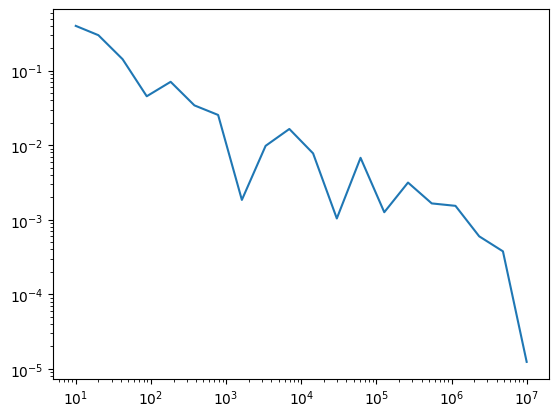

In [5]:
n_shots_s = [int(10**i) for i in np.linspace(1, 7, 20)]
error_s = np.abs(np.array([method_1_estimator(0, 0, get_counts_using_aer, n_shots) for n_shots in n_shots_s]))
print(error_s)


-0.5389433246739697 -0.062109747024688904
Line of best fit is |error| = 0.94 n_shots^-0.54


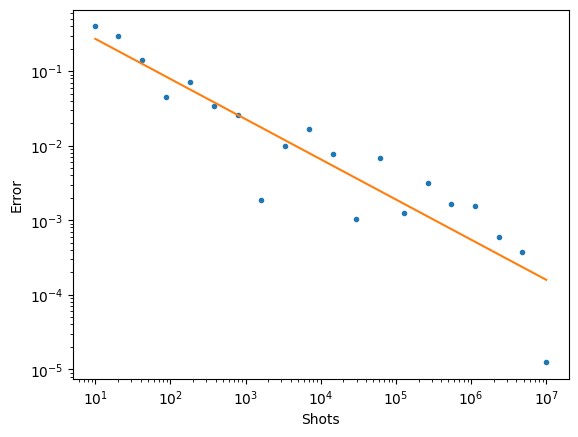

In [25]:
plt.plot(n_shots_s, error_s, '.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Shots')
plt.ylabel('Error')
a,b = np.polyfit(np.log(n_shots_s := np.array(n_shots_s)), np.log(error_s := np.array(error_s)), 1)
print(a, b)
plt.plot(n_shots_s, np.exp(b)*n_shots_s**a)
print(f"Line of best fit is |error| = {np.exp(b):.2f} n_shots^{a:.2f}")

## Method evaluation

In [3]:
err_1_aer = evaluate_method(method_1_estimator, get_counts_using_aer, 1000, 'Method 1 with aer')
err_2_aer = evaluate_method(method_2_estimator, get_counts_using_aer, 1000, 'Method 2 with aer')
err_1_qpu = evaluate_method(method_1_estimator, get_counts_using_real_qpu, 1000, 'Method 1 with real qpu')
err_2_qpu = evaluate_method(method_2_estimator, get_counts_using_real_qpu, 1000, 'Method 2 with real qpu')

Evaluating Method 1 with aer...
0.008
0.41
Method 1 with aer has errors of 8.0e-03 and 2.7e-02 (7.1%) for the two examples.
Evaluating Method 2 with aer...
draw
-0.032 0.008
draw
0.008 1.0
Method 2 with aer has errors of 1.7e-02 and 7.4e-03 (1.9%) for the two examples.
Evaluating Method 1 with real qpu...
Selecting backend...
Selected backend: ibm_kyiv
-0.012
Selecting backend...
Selected backend: ibm_kyiv
0.342
Method 1 with real qpu has errors of 1.2e-02 and 4.1e-02 (10.6%) for the two examples.
Evaluating Method 2 with real qpu...
draw
Selecting backend...
Selected backend: ibm_kyiv
0.0 0.012
draw
Selecting backend...
Selected backend: ibm_kyiv
0.046 1.0
Method 2 with real qpu has errors of 8.5e-03 and 4.2e-02 (11.1%) for the two examples.


#### Sample output:

Evaluating Method 1 with aer...

Method 1 with aer has errors of 2.8e-02 and 3.7e-02 (9.8%) for the two examples.

Evaluating Method 2 with aer...

Method 2 with aer has errors of 2.8e-02 and 5.5e-03 (1.4%) for the two examples.

Evaluating Method 1 with real qpu...

Selecting backend...

Selected backend: ibm_kyiv

Selecting backend...

Selected backend: ibm_kyiv

Method 1 with real qpu has errors of 4.0e-03 and 2.9e-02 (7.7%) for the two examples.

Evaluating Method 2 with real qpu...

Selecting backend...

Selected backend: ibm_kyiv

Selecting backend...

Selected backend: ibm_kyiv

Method 2 with real qpu has errors of 1.4e-02 and 3.2e-02 (8.3%) for the two examples.

Text(0, 0.5, 'Absolute error from true EV')

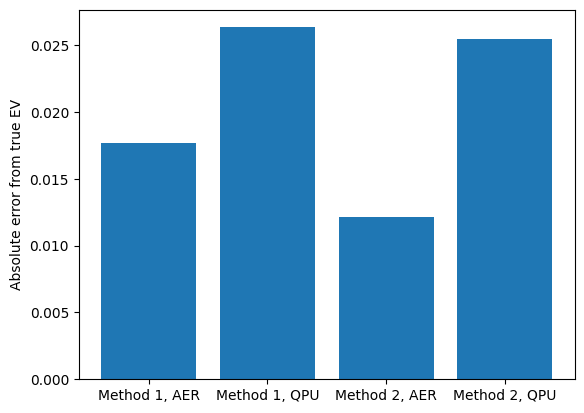

In [4]:
# Plot errors for various methods
plt.bar(['Method 1, AER', 'Method 1, QPU', 'Method 2, AER', 'Method 2, QPU'],
         [(a+b)/2 for a,b in [err_1_aer, err_1_qpu, err_2_aer, err_2_qpu]])
plt.ylabel('Absolute error from true EV')